In [1]:
import os
import sys
from pathlib import Path

lib_dir = Path("..") #folder cotaining dir paysim_analysis
module_path = os.path.abspath(os.path.join(lib_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from paysim_analysis.classification import *
from paysim_analysis.utils import get_project_folder
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score, plot_roc_curve
import seaborn as sn
import matplotlib.pyplot as plt


In [3]:
dir_ = get_project_folder().parent / "data" 
target = "isFraud"

In [4]:
#datasets

#tomek_links_df = pd.read_csv(dir_ / "balanced_datasets/tomek_links_balanced.csv")
smote_df = pd.read_csv(dir_ / "balanced_datasets/smote_balanced.csv")
near_miss3_df = pd.read_csv(dir_ / "balanced_datasets/near_miss3_balanced.csv")
df_unbalanced = pd.read_csv(dir_ / "processed/PS_20174392719_1491204439457_log.csv")

np.random.seed(42)
#print(len(tomek_links_df))
print(len(smote_df))
print(len(near_miss3_df))
print(len(df_unbalanced))

400000
16426
2770409


## SVM on the unbalanced dataset

We use the original dataset (we just apply z-score normalization) and force SVM to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

In [5]:
%%time
model, y_pred, y_test = svm_on_unbalanced_df(df_unbalanced, target)

/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CPU times: user 8min 56s, sys: 4.16 s, total: 9min
Wall time: 10min 10s


In [6]:
print("Preision, Recall, F1, Score :", precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("MCC", matthews_corrcoef(y_test, y_pred))
print("AUC", roc_auc_score(y_test, y_pred))

Preision, Recall, F1, Score : (0.5512390993553237, 0.9336586392405266, 0.5862442422177777, None)
MCC 0.2981293551620829
AUC 0.9336586392405266


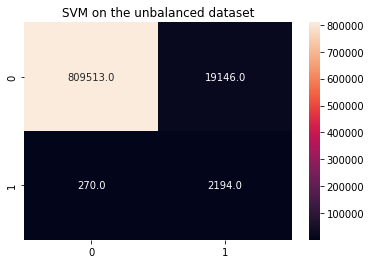

In [7]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
ax = sn.heatmap(cm, annot=True, fmt=".1f")

ax.set_title('SVM on the unbalanced dataset')
plt.show()

## SVM on balanced datasets

### NearMiss 3

In [8]:
%%time
scores, mean_scores = svm_on_balanced_df(near_miss3_df, target, verbose=False)
mean_scores

/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CPU times: user 75.2 ms, sys: 114 ms, total: 189 ms
Wall time: 8.04 s


/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs

{'fit_time': 5.75,
 'score_time': 0.02,
 'test_precision_macro': 0.8,
 'test_recall_macro': 0.77,
 'test_f1_macro': 0.77,
 'test_roc_auc': 0.85,
 'test_matthews_corrcoef': 0.58}

### Hybrid Approach

In [9]:
%%time
scores, mean_scores = svm_on_balanced_df(smote_df, target, verbose=False)
mean_scores

/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs/qonto/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lanottef/anaconda3/envs

CPU times: user 127 ms, sys: 129 ms, total: 256 ms
Wall time: 3min 32s


{'fit_time': 210.27,
 'score_time': 0.14,
 'test_precision_macro': 0.92,
 'test_recall_macro': 0.92,
 'test_f1_macro': 0.92,
 'test_roc_auc': 0.98,
 'test_matthews_corrcoef': 0.83}

### One Class SVM
In this case, the goal is to capture density of the majority class and classifies examples on the extremes of the density function as outliers.

In [10]:
frauds = df_unbalanced[target]

oneclass_df = df_unbalanced[~frauds]

training_df = oneclass_df.sample(n=200000)
test_1_df = df_unbalanced[frauds]
test_0_df = oneclass_df.sample(n=len(test_1_df))
test_df = pd.concat([test_1_df, test_0_df])
model, y_pred = one_class_svm(training_df, test_df, target)

In [11]:
# mark inliers 1, outliers -1
y_test = test_df[target].astype(int)
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1

print("Preision, Recall, F1, Score :", precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("MCC", matthews_corrcoef(y_test, y_pred))
print("AUC", roc_auc_score(y_test, y_pred))

Preision, Recall, F1, Score : (0.7737685998198118, 0.6563375136977961, 0.6150579810883713, None)
MCC 0.41376467816553075
AUC 0.6563375136977961


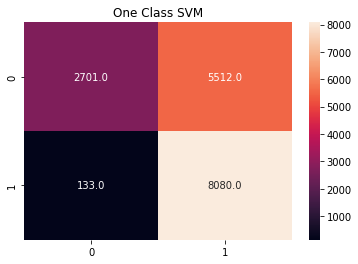

In [12]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
ax = sn.heatmap(cm, annot=True, fmt=".1f")

ax.set_title('One Class SVM')
plt.show()